# Estimating circular quantities using qinfer

This notebook demonstrates how to use custom particle-mean and particle-covariance functions in `qinfer`. 
As an example, we deal with the problem of estimating a phase variable confined to the interval $[0, 2\pi]$.

This feature requires `qinfer > 1.0`. 
Currently, only the dev version from github with commit id > `41ddbad11fdd4b4cca9348072b4cbfb6cdd20cbd` support this feature.

In [1]:
import qinfer as qi
import matplotlib.pyplot as pl
import numpy as np

/Users/dsuess/Library/Miniconda3/envs/qinfer/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/dsuess/Code/Qinfer/src/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


We will be dealing with the task of estimating $\phi \in [0, 2\pi)$ from noisy observations $Y = \mathrm{mod}_{2\pi}(\phi + \sigma \epsilon)$, where $\sigma > 0$ is a known constant and $\epsilon \sim \mathcal{N}(0, 1)$ is a standard normal random variable.
As we will show below, the standard resampler used in `qinfer` cannot deal with this setting due to the periodicity.

First, let us define the model.
To keep this example simple, we do not use the fact that our problem would allow for using `qinfer.DifferentiableModel`.

In [2]:
class CircularModel(qi.Model):
    def __init__(self, sigma=.01):
        super(CircularModel, self).__init__()
        self.sigma = sigma
        
    @property
    def n_modelparams(self):
        return 1
    
    @property
    def expparams_dtype(self):
        # We do not have any external parameters to be adjusted
        return []
    
    @property
    def is_n_outcomes_constant(self):
        return True
    
    @property
    def n_outcomes(self):
        return 1
    
    def domain(self, _):
        # specify the domain of \phi
        return qi.RealDomain(min=0, max=2 * np.pi)
        
    def are_models_valid(self, modelparams):
        return (modelparams[..., 0] >= 0) * (modelparams[..., 0] < 2 * np.pi)
    
    def canonicalize(self, modelparams):
        return np.mod(modelparams, 2 * np.pi)
    
    def simulate_experiment(self, modelparams, expparams, repeat=1):
        x = modelparams[None, :,  None] + self.sigma * np.random.randn(repeat)
        return self.canonicalize(x)
    
    def likelihood(self, outcomes, modelparams, expparams):
        super(CircularModel, self).likelihood(outcomes, modelparams, expparams)
        nr_summands = np.ceil(self.sigma / np.pi) + 3
        n = np.arange(-nr_summands, nr_summands + 1)[:, None, None]
        x = outcomes[None, :, None] - modelparams[None, None, :, 0] + 2 * np.pi * n
        x /= self.sigma
        p = 1 / np.sqrt(2 * np.pi * self.sigma**2) * np.exp(- x * x / 2)
        return np.sum(p, axis=0)[..., None]

The only function in this model that needs some more explanation is the `likelihood` function. 
Due to the `\mathrm{mod}` operation in the statistical model, the likelihood of an observation $y$ is given by
$$\mathbb{P}(Y=y | \phi) = \sum_{k=-\infty}^\infty \mathbb{P}(\epsilon=y - \phi - 2\pi k)$$
Recall that $\epsilon$ was a standard normal random variable.
To evaluate the right hand side, we truncate the sum and only consider summands $k=-K, ..., K$ which substantially contribute to the sum.
We choose $K$ to be $\lceil \sigma / \pi \rceil + 3$, which makes sure that any contribution with $k > K$ is negligible.

In [3]:
def weights_to_markersize(weights, maxsize=30):
    return maxsize * weights / np.max(weights)

First, let us demonstrate that the model works well in cases where the boundary "is not felt", that is where the true vallue $\phi$ lies well inside  the domain.
For this we sample `NR_OUTCOMES` outcomes with $\phi = 4$ and $\sigma = 1$.
This data is then used to update a uniform prior on $[0, 2\pi)$.

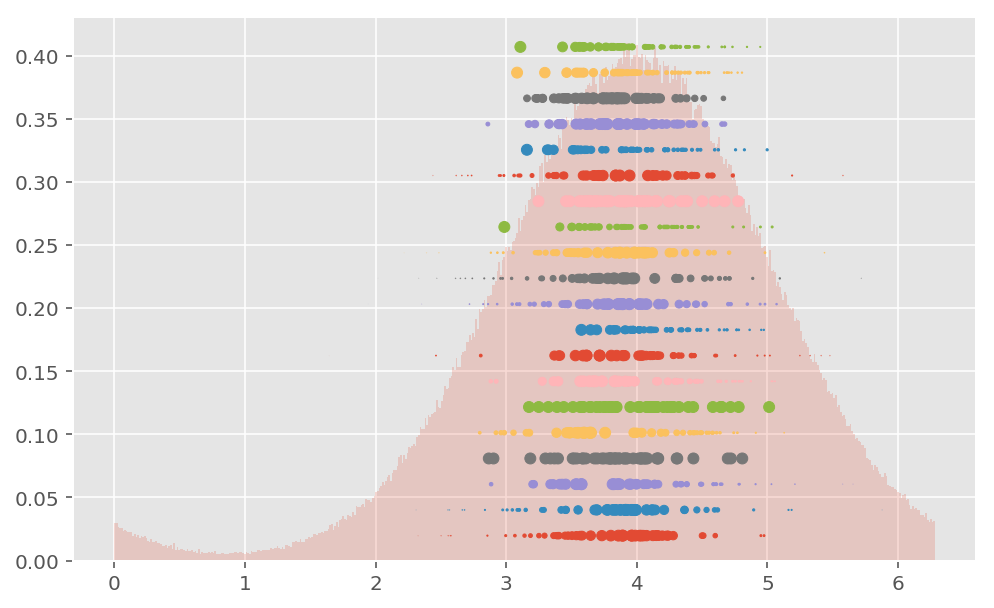

In [4]:
# nr of particles for the particle filter
PARTICLES = 50
# nr of measurements to be sampled
NR_OUTCOMES = 10

ax = pl.subplot(111)
twinx = ax.twinx()
twinx.set_yticks([])
np.random.seed(1234)

# specify the true model parameters
modelparams_true = np.array([4])
model = CircularModel(sigma=1.)
# sample outcomes to be used for inference
outcomes = model.simulate_experiment(modelparams_true, [], repeat=NR_OUTCOMES).ravel()
resampler = qi.LiuWestResampler(a=0.0)

for i in range(20):
    prior = qi.UniformDistribution(ranges=np.array([0, 2 * np.pi]))
    updater = qi.SMCUpdater(model, PARTICLES, prior, resampler=resampler)
    updater.batch_update(outcomes, np.empty((NR_OUTCOMES)), resample_interval=1)
    twinx.scatter(updater.particle_locations, i * np.ones(PARTICLES),
                  s=weights_to_markersize(updater.particle_weights))
    
# let us also approximate the distribution of $Y$ with a histogram over many samples
ax.hist(model.simulate_experiment(modelparams_true, [], repeat=1000000).ravel(),
                       bins=500, normed=True, alpha=.2);

Besides the approximated density of $Y$, the above plot show the positions and weights of the particle approximation of the posterior for 20 independent runs.
The choice `a = 0` for the Liu-West resampler and the forced resampling after each update step will become clear below.
Just notice that the inference worked well and the particle mean would constitute a viable estimate of the true value.
Since the particles concentrate around the mean, the estimate would also provide a relatively small uncertainty region.

Let us now run the same simulation, but with $\phi = 0.001$, that is with $\phi$ very close to the boundary.

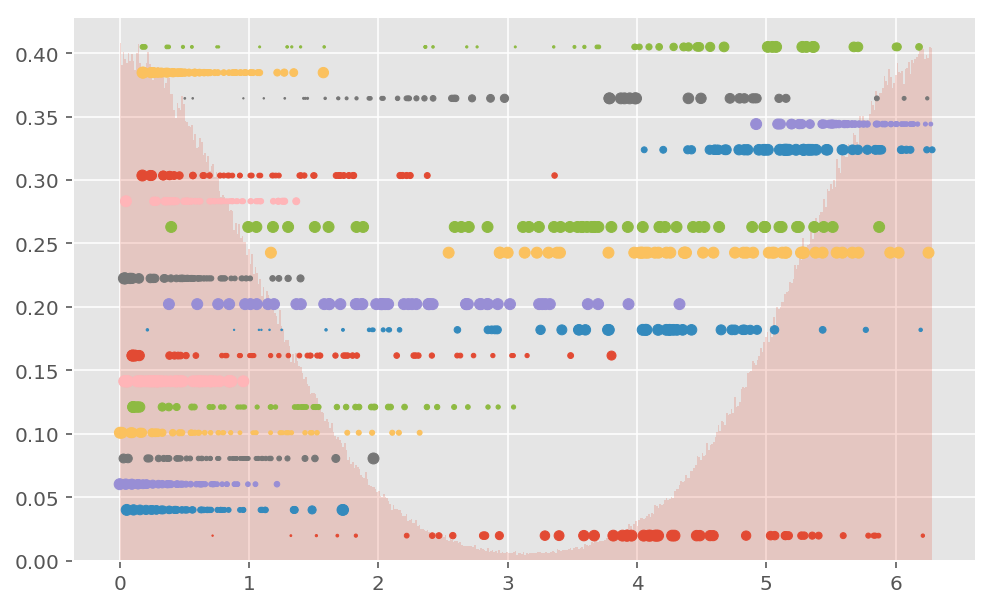

In [5]:
ax = pl.subplot(111)
twinx = ax.twinx()
twinx.set_yticks([])
np.random.seed(1234)

# specify the true model parameters
modelparams_true = np.array([0.001])
model = CircularModel(sigma=1.)
# sample outcomes to be used for inference
outcomes = model.simulate_experiment(modelparams_true, [], repeat=NR_OUTCOMES).ravel()
resampler = qi.LiuWestResampler(a=0.0)

for i in range(20):
    prior = qi.UniformDistribution(ranges=np.array([0, 2 * np.pi]))
    updater = qi.SMCUpdater(model, PARTICLES, prior, resampler=resampler)
    updater.batch_update(outcomes, np.empty((NR_OUTCOMES)), resample_interval=1)
    twinx.scatter(updater.particle_locations, i * np.ones(PARTICLES),
                  s=weights_to_markersize(updater.particle_weights))
    
# let us also approximate the distribution of $Y$ with a histogram over many samples
ax.hist(model.simulate_experiment(modelparams_true, [], repeat=1000000).ravel(),
                       bins=500, normed=True, alpha=.2);

Clearly, the particle approximation to the posterior is all over the place and very sensetive to the initial sample. 
The reason for this behaviour lies in the resampling step:
The goal of resampling is to counteract the trend that with an increasing number of update steps, the particle weight usually concentrates on very few of the particles.
There are two basic strategies how the Liu-West resampler determines the position of the new particles:
- in either samples the old positions of the particles according to their weight (and may add small additional noise to obtain slightly different locations from particles with a high weight)
- it approximates the current particle distribution using a Gaussian distribution and samples the new locations from it.
Which strategy we choose depends on the parameter `a`.
For our choice `a = 0`, we only employ the latter strategy.

This however is problematic for circular quantities.
For example consider two two particles with equal weight and locations $\varphi_1 = 0.0001$ and $\varphi_2 = 2\pi - 0.0001$.
Their arithmetic mean is $\pi$.
The corresponding Gaussian approximation using the arithmetic mean and variance is of course very bad when we consider the $\varphi_i$ to be angle variables.

In [6]:
particle_locations = np.array([[0.0001], [2 * np.pi - 0.0001]])
particle_weights = np.array([.5, .5])

mean = qi.ParticleDistribution.particle_mean(particle_weights,  particle_locations)
var = qi.ParticleDistribution.particle_covariance_mtx(particle_weights, particle_locations)
print("Mean: {}   Variance: {}".format(mean[0], var[0, 0]))

Mean: 3.14159265359   Variance: 9.86897609256


In order to fix the resampling step, we have to use definitions of mean and variance appropriate for circular quantities, namely circular mean and variance.
Taking the circular mean of angles corresponds to translating these angles to points on the unit circle, taking the arithmetic mean of the points, and projecting the mean back on the unit circle.
The variance can be also be obtained from the length of the unprojected mean.
For more information, see [wikipedia](https://en.wikipedia.org/wiki/Mean_of_circular_quantities).

In `qinfer`, we can provide custom particle-mean and covariance functions, which are then used by the resampler instead.
This can be done by subclassing `qinfer.ParticleDistribution` and overwriting the `particle_mean` and `particle_covariance_mtx` functions.
Both should take the weights and locations as arguments.

In [7]:
def cart2pol(x, y):
    """Transform 2D carthesian coordinates to polar coordinates"""
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

def pol2cart(rho, phi):
    """Transform 2D polar coordinates to carthesian coordinates"""
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y


def circular_particle_mean(weights, angles):
    """Computes the weighted circular mean and returns the mean
    amplitude (used for computing the variance) as well as the
    mean angle.
    """
    x, y = pol2cart(1, angles)
    meanfunc = qi.ParticleDistribution.particle_mean
    mean_x = meanfunc(weights, x)
    mean_y = meanfunc(weights, y)
    mean_amplitude, mean_angle = cart2pol(mean_x, mean_y)
    return mean_amplitude, np.mod(mean_angle, 2 * np.pi)


class CircularDistribution(qi.ParticleDistribution):
    @staticmethod
    def particle_mean(weights, locations):
        _, mean_angle = circular_particle_mean(weights, locations)
        return mean_angle
    
    @staticmethod
    def particle_covariance_mtx(weights, locations):
        mean_amplitude, _ = circular_particle_mean(weights, locations)
        return np.reshape(1 - mean_amplitude, (1, 1))

Note that both functions are defined as `staticmethod`, that means they cannot use any instance variables of any instance of `qinfer.ParticleDistribution`.
Now, the mean and variance of the above 2 particles makes more sense:

In [8]:
mean = CircularDistribution.particle_mean(particle_weights,  particle_locations)
var = CircularDistribution.particle_covariance_mtx(particle_weights, particle_locations)
print("Mean: {}   Variance: {}".format(mean[0], var[0, 0]))

Mean: 6.28318530718   Variance: 4.99999996961e-09


Finally, in order for the updater class to use these newly defined functions for resampling, we simply derive a new class where the newly defined particle mean and covariance functions take precedence.

In [9]:
class CircularSMCUpdater(qi.SMCUpdater, CircularDistribution):
    pass

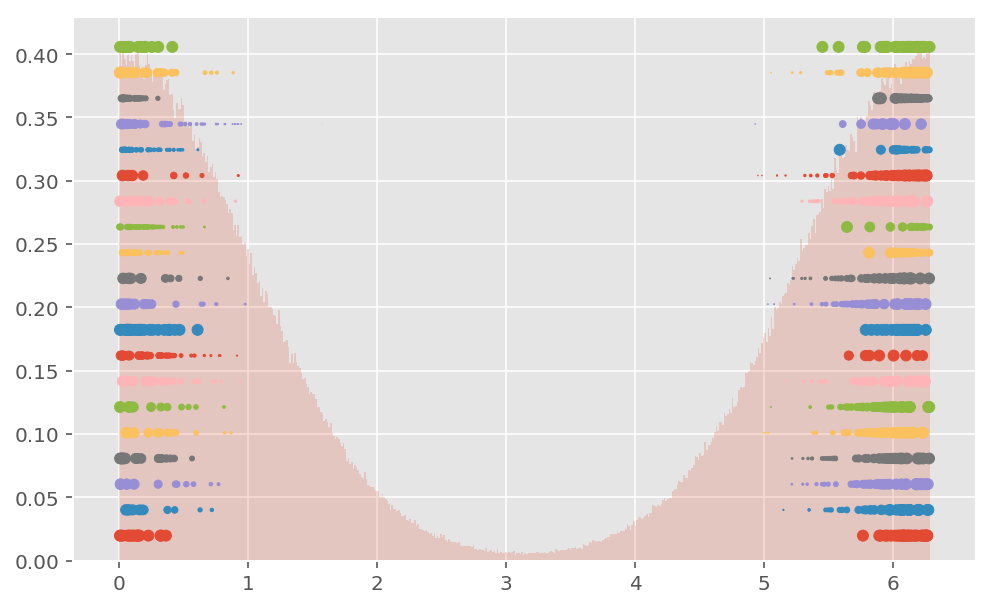

In [10]:
ax = pl.subplot(111)
twinx = ax.twinx()
twinx.set_yticks([])
np.random.seed(1234)

# specify the true model parameters
modelparams_true = np.array([0.001])
model = CircularModel(sigma=1.)
# sample outcomes to be used for inference
outcomes = model.simulate_experiment(modelparams_true, [], repeat=NR_OUTCOMES).ravel()
# We need to disable postselection in the resampler since otherwise we loose the 
# new particle locations outside of [0, 2pi]
# This is a workaround for not using particle_mean in resamplers.py:322
resampler = qi.LiuWestResampler(a=0.0, postselect=False)

for i in range(20):
    prior = qi.UniformDistribution(ranges=np.array([0, 2 * np.pi]))
    # We have to canonicalize since we disabled postselection
    updater = CircularSMCUpdater(model, PARTICLES, prior, resampler=resampler,
                                 canonicalize=True)
    updater.batch_update(outcomes, np.empty((NR_OUTCOMES)), resample_interval=1)
    twinx.scatter(updater.particle_locations, i * np.ones(PARTICLES),
                  s=weights_to_markersize(updater.particle_weights))
    
# let us also approximate the distribution of $Y$ with a histogram over many samples
ax.hist(model.simulate_experiment(modelparams_true, [], repeat=1000000).ravel(),
                       bins=500, normed=True, alpha=.2);

Note how the new particle estimates closely resemble the above case, where $\phi$ was far away from the domain boundaries.
Also, due to optimizations in the resampler, we have to disable postselection and cannonicalize the particles each time.